In [1]:
import json
import numpy as np
import pandas as pd

# Training Data Processing
file = "../input/deepeyenet/DeepEyeNet_train.json"
with open(file) as train_file:
    dict_train = json.load(train_file)

paths,labels,keywords,descs = [],[],[],[]
for i in range(len(dict_train)):
    paths.append(list(dict_train[i].keys())[0])
    keywords.append(list(dict_train[i].values())[0]['keywords'])
    descs.append(list(dict_train[i].values())[0]['clinical-description'])
    
train_data = pd.DataFrame({"image_path":paths, "keywords":keywords, "caption":descs})
train_data.to_csv('train_data.csv')

# Testing Data Processing
file = "../input/deepeyenet/DeepEyeNet_test.json"
with open(file) as test_file:
    dict_test = json.load(test_file)

paths,labels,keywords,descs = [],[],[],[]
for i in range(len(dict_test)):
    paths.append(list(dict_test[i].keys())[0])
    keywords.append(list(dict_test[i].values())[0]['keywords'])
    descs.append(list(dict_test[i].values())[0]['clinical-description'])
    
test_data = pd.DataFrame({"image_path":paths, "keywords":keywords, "caption":descs})
test_data.to_csv('test_data.csv')

# Validation Data Processing
file = "../input/deepeyenet/DeepEyeNet_valid.json"
with open(file) as valid_file:
    dict_valid = json.load(valid_file)

paths,labels,keywords,descs = [],[],[],[]
for i in range(len(dict_valid)):
    paths.append(list(dict_valid[i].keys())[0])
    keywords.append(list(dict_valid[i].values())[0]['keywords'])
    descs.append(list(dict_valid[i].values())[0]['clinical-description'])
    
valid_data = pd.DataFrame({"image_path":paths, "keywords":keywords, "caption":descs})
valid_data.to_csv('valid_data.csv')

In [2]:
import os
import re
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import TextVectorization


seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
## Desired image dimensions
IMAGE_SIZE = (356, 356)

# Vocabulary size
VOCAB_SIZE = 5000

# Fixed length allowed for any sequence
SEQ_LENGTH = 50
MIN_SEQ_LEN = 5

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 1024

# Per-layer units in the feed-forward network
FF_DIM = 1024

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
def load_captions_data(filename):
    
    data = pd.read_csv(filename)
    caption_data = list(data['caption'].values)
    images = list(data['image_path'].values)
    keywords_data = list(data['keywords'].values)
    caption_mapping = {}
    text_data = []
    images_to_skip = set()

    for i in range(len(caption_data)):
        img_name = '../input/deepeyenet/'+images[i] 
        caption = caption_data[i].rstrip("\n")
        keywords = '[sep]'.join ([kw.strip() for kw in train_data['keywords'][i].split(",")])

        # We will remove caption that are either too short to too long
        tokens = caption.strip().split()

        if len(tokens) < MIN_SEQ_LEN or len(tokens) > SEQ_LENGTH:
            images_to_skip.add(img_name)
            continue

        if img_name.endswith("jpg") and img_name not in images_to_skip:
            # We will add a start and an end token to each caption
            caption = caption.replace('-', ' ')
            caption = "<start> " + caption.strip() + " <end>"
            text_data.append(caption)
            text_data.append(keywords)

            if img_name not in caption_mapping:
                caption_mapping[img_name] = [caption]
                caption_mapping[img_name].append(keywords)
            else:
                pass
                

    for img_name in images_to_skip:
        if img_name in caption_mapping:
            del caption_mapping[img_name]

    return caption_mapping, text_data

In [5]:
# Load the dataset
train_captions_mapping, train_text_data = load_captions_data("./train_data.csv")
valid_captions_mapping, valid_text_data = load_captions_data("./valid_data.csv")
test_captions_mapping, test_text_data = load_captions_data("./test_data.csv")

In [6]:
train_captions_mapping.update(valid_captions_mapping)
train_text_data = np.concatenate((train_text_data, valid_text_data), axis=None)

In [7]:
print("Number of training samples: ", len(train_captions_mapping))
print("Number of testing samples: ", len(test_captions_mapping))

Number of training samples:  8825
Number of testing samples:  2430


In [9]:
# complete text data for captions
text_data = np.concatenate((train_text_data, test_text_data), axis=None)

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

In [11]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, caption):
    img = decode_and_resize(img_path)
    caption_vector = vectorization(caption)
    return (img, caption_vector[1]), caption_vector[0]


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset


# Pass the list of images and the list of corresponding captions & Keywords
train_dataset = make_dataset(list(train_captions_mapping.keys()), list(train_captions_mapping.values()))
valid_dataset = make_dataset(list(valid_captions_mapping.keys()), list(valid_captions_mapping.values()))
test_dataset = make_dataset(list(test_captions_mapping.keys()), list(test_captions_mapping.values()))

In [ ]:
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Softmax
from keras.layers import Permute
from keras.layers import add, dot

from keras import backend as K


def GlobalContextBlock(ip, reduction_ratio=8, transform_activation='linear'):
    """
    Adds a Global Context attention block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).

    # Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        reduction_ratio: Reduces the input filters by this factor for the
            bottleneck block of the transform submodule. Node: the reduction
            ratio must be set such that it divides the input number of channels,
        transform_activation: activation function to apply to the output
            of the transform block. Can be any string activation function availahle
            to Keras.

    # Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    if rank > 3:
        flat_spatial_dim = -1 if K.image_data_format() == 'channels_first' else 1
    else:
        flat_spatial_dim = 1

    """ Context Modelling Block """
    # [B, ***, C] or [B, C, ***]
    input_flat = _spatial_flattenND(ip, rank)
    # [B, ..., C] or [B, C, ...]
    context = _convND(ip, rank, channels=1, kernel=1)
    # [B, ..., 1] or [B, 1, ...]
    context = _spatial_flattenND(context, rank)
    # [B, ***, 1] or [B, 1, ***]
    context = Softmax(axis=flat_spatial_dim)(context)

    # Compute context block outputs
    context = dot([input_flat, context], axes=flat_spatial_dim)
    # [B, C, 1]
    context = _spatial_expandND(context, rank)
    # [B, C, 1...] or [B, 1..., C]

    """ Transform block """
    # Transform bottleneck
    # [B, C // R, 1...] or [B, 1..., C // R]
    transform = _convND(context, rank, channels // reduction_ratio, kernel=1)
    # Group normalization acts as Layer Normalization when groups = 1
    #transform = GroupNormalization(groups=1, axis=channel_dim)(transform)
    transform = Activation('relu')(transform)

    # Transform output block
    # [B, C, 1...] or [B, 1..., C]
    transform = _convND(transform, rank, channels, kernel=1)
    transform = Activation(transform_activation)(transform)

    # apply context transform
    out = add([ip, transform])

    return out


def _convND(ip, rank, channels, kernel=1):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv1D(channels, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (kernel, kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)

    return x


def _spatial_flattenND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    ip_shape = K.int_shape(ip)
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = ip  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3]]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [ip_shape[1] * ip_shape[2], ip_shape[3]]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3] * ip_shape[4]]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [ip_shape[1] * ip_shape[2] * ip_shape[3], ip_shape[4]]

        x = Reshape(shape)(ip)

    return x


def _spatial_expandND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = Permute((2, 1))(ip)  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [-1, 1, 1]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [1, 1, -1]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [-1, 1, 1, 1]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [1, 1, 1, -1]

        x = Reshape(shape)(ip)

    return x

from keras import backend as K
from keras.layers import Layer

class AttentionGate(Layer):
    def __init__(self, filters, **kwargs):
        self.filters = filters
        super(AttentionGate, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable parameters for attention gate
        self.Wx = self.add_weight(name='Wx',
                                 shape=(input_shape[0][-1], self.filters),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.Wg = self.add_weight(name='Wg',
                                 shape=(input_shape[1][-1], self.filters),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.psi = self.add_weight(name='psi',
                                  shape=(self.filters, 1),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.bxg = self.add_weight(name='bxg',
                                  shape=(self.filters,),
                                  initializer='zeros',
                                  trainable=True)
        self.bpsi = self.add_weight(name='bpsi',
                                   shape=(1,),
                                   initializer='zeros',
                                   trainable=True)
        super(AttentionGate, self).build(input_shape)

    def call(self, inputs):
        xl, g = inputs

        # Compute additive attention
        att = K.relu(K.dot(xl, self.Wx) + K.dot(g, self.Wg) + self.bxg)
        att = K.dot(att, self.psi) + self.bpsi
        att = K.sigmoid(att)

        # Apply attention gate
        x_hat = att * xl

        return x_hat

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [13]:
def get_cnn_model():
    base_model = EfficientNetV2B0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = True
    fmaps = base_model.output #base_model.get_layer('block4_pool').output
    context_fmaps = GlobalContextBlock(fmaps) # Global Context Attention Layer
    att_fmaps = AttentionGate(fmaps.shape[-1])([fmaps, context_fmaps]) #Context Gating Layer
    model_out = layers.Reshape((-1, att_fmaps.shape[-1]))(att_fmaps)
    cnn_model = keras.models.Model(base_model.input, model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,vocab_size,max_seq_length,  **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, image_features, keywords, training, mask=None):
        
        image_features = self.layernorm_1(image_features)
        image_features = self.dense_1(image_features)
        
        keyword_embeddings = self.embedding(keywords)
        att_keyword_embeddings = self.mha(keyword_embeddings, keyword_embeddings)
        keyword_embeddings_att = tf.keras.layers.Reshape((self.max_seq_length, self.embed_dim))(att_keyword_embeddings)

        attention_output_1 = self.attention_1(
            query=image_features,
            key=keyword_embeddings_att,
            value=keyword_embeddings,
            attention_mask=None,
            training=training,
        )
        
        out_1 = self.layernorm_2(image_features + attention_output_1)
        
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = tf.cast(embedded_tokens, tf.float32) * self.embed_scale
        embedded_positions = tf.cast(self.position_embeddings(positions), tf.float32)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + tf.cast(attention_output_1, tf.float32))

        attention_output_2, attention_scores = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
            return_attention_scores=True
        )
        self.last_attention_scores = attention_scores
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=1,):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_keywords, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, batch_keywords, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img_keywords, batch_seq = batch_data
        batch_img, batch_keywords = batch_img_keywords
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_keywords, batch_seq, training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img_keywords, batch_seq = batch_data
        batch_img, batch_keywords = batch_img_keywords
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_keywords, batch_seq, training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2,vocab_size=VOCAB_SIZE,max_seq_length=SEQ_LENGTH)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=5)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder,)

24274472/24274472 [==============================] - 2s 0us/step


In [14]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // BATCH_SIZE

from keras.optimizers import RMSprop
class GCRMSprop(RMSprop):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= ops.mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)
optimizer = GCRMSprop(lr_schedule)

# Compile the model
caption_model.compile(optimizer=optimizer, loss=cross_entropy)#keras.optimizers.Adam(lr_schedule)

# Fit the model
history = caption_model.fit(train_dataset,epochs=EPOCHS,validation_data=test_dataset,verbose=1)

# Save model weights
filepath = "/kaggle/working/weights.best.tf"
caption_model.save_weights(filepath, save_format="tf")

Epoch 1/25
138/138 [==============================] - 206s 1s/step - loss: 5.9176 - acc: 0.1242 - val_loss: 3.6836 - val_acc: 0.3947
Epoch 2/25
138/138 [==============================] - 139s 1s/step - loss: 3.7602 - acc: 0.3438 - val_loss: 3.1189 - val_acc: 0.4393
Epoch 3/25
138/138 [==============================] - 135s 982ms/step - loss: 3.0527 - acc: 0.4354 - val_loss: 2.8988 - val_acc: 0.4622
Epoch 4/25
138/138 [==============================] - 136s 988ms/step - loss: 2.6437 - acc: 0.4938 - val_loss: 2.7678 - val_acc: 0.4761
Epoch 5/25
138/138 [==============================] - 135s 983ms/step - loss: 2.3489 - acc: 0.5337 - val_loss: 2.6686 - val_acc: 0.4880
Epoch 6/25
138/138 [==============================] - 138s 1s/step - loss: 2.1047 - acc: 0.5743 - val_loss: 2.5974 - val_acc: 0.5026
Epoch 7/25
138/138 [==============================] - 138s 1s/step - loss: 1.9156 - acc: 0.6070 - val_loss: 2.5380 - val_acc: 0.5116
Epoch 8/25
138/138 [==============================] - 139s 1

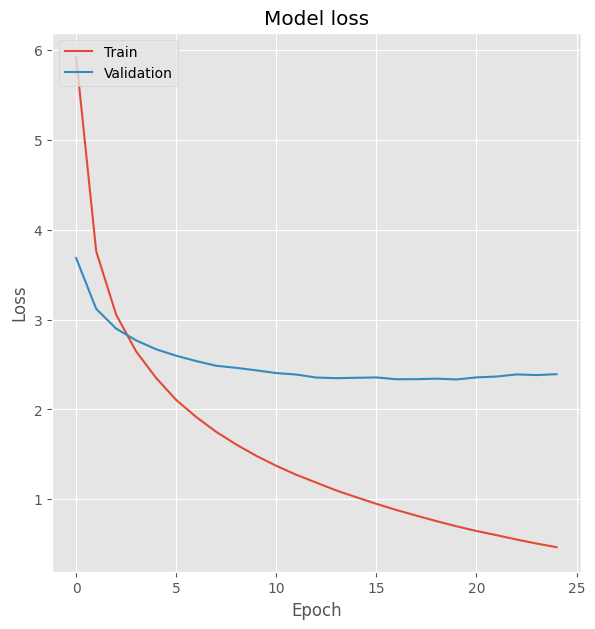

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('ggplot')

# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

hist = history

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

beam_width = 3

def beam_search(predictions, beam_width=3, max_length=SEQ_LENGTH):
    # Start with an empty beam
    beams = [([], 1.0)]
    
    # Iterate over each predicted word probabilities
    for word_probs in predictions:
        new_beams = []
        
        # Expand each beam with all possible next words
        for beam in beams:
            prev_tokens, prev_prob = beam
            for i in range(beam_width):
                word = np.argmax(word_probs)
                prob = np.max(word_probs)
                new_beams.append((prev_tokens + [word], prev_prob * prob))
                word_probs = np.where(word_probs == np.max(word_probs), -float('inf'), word_probs)  # Remove the selected word from future consideration
        
        # Select the top beams based on their probabilities
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_width]
        
        # Stop if the maximum length is reached or all beams end with the end token
        if len(beams[0][0]) == max_length or all([beam[0][-1] == "<end>" for beam in beams]):
            break
    
    # Return the best caption word indices
    return beams[0][0]

def generate_caption(img_path, keywords, img_verbose, beam_seach=True):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img.numpy().clip(0, 255).astype(np.uint8)
    
    # display image if img_verbose=True
    if img_verbose:
        plt.grid(False)
        plt.imshow(img)
        plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(img, 0)
    img = caption_model.cnn_model(img)
    
    # Get keyword vector
    keywords = vectorization(keywords)
    keywords = tf.expand_dims(keywords, 0)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, keywords, training=False)

    # Generate the caption using beam search
    decoded_caption = "<start> "
    predictions = []
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        prediction = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        predictions.append(prediction[0, i, :])
        sampled_token_index = np.argmax(prediction[0, i, :])
        decoded_caption += " " + index_lookup[sampled_token_index]
    
    # find cpation through beam serach if beam_serach=True
    if beam_search:
        predictions_np = [pred.numpy() for pred in predictions]
        caption_indices = beam_search(predictions_np, beam_width, max_decoded_sentence_length)
        decoded_caption = ' '.join([index_lookup[index] for index in caption_indices])
    
    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    return decoded_caption

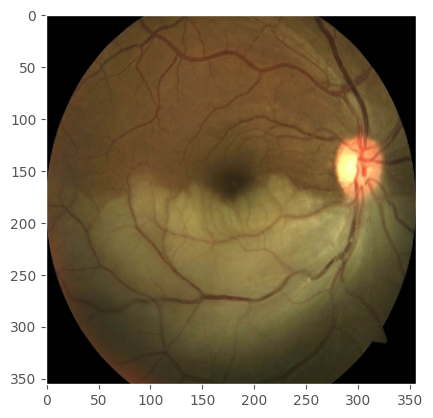

fundus photograph of a 25 year old man with coats disease


In [17]:
img_path = '/kaggle/input/deepeyenet/eyenet0420/test_set/group13-6.jpg'
kws = 'branch retinal artery occlusion (brao)[sep]pan-retinal photocoagulation (prp)[sep]hollenhorst plaque'
pred_caption = generate_caption(img_path, kws, img_verbose=True)
print(pred_caption)

In [ ]:
# Compute BLUE Score
import nltk
!pip install rouge
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

def decode_tokens(tokens):
    decoded_caption = ""
    for token_index in tokens:
        sampled_token = index_lookup[token_index]
        decoded_caption += " " + sampled_token
    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    return decoded_caption

def evaluate_caption_model(test_data, empty_keywords=True, blue_score=True, cider_score=False, rouge_score=False, img_verbose=False, save_to_file=False, limit=100):
    
    img_paths = test_data['image_path'].values
    exp_keywords = test_data['keywords'].replace(np.nan, '', regex=True).values
    captions = test_data['caption'].values
    img_root_dir = "/kaggle/input/deepeyenet/"
    
    limit_counter, index = 0, 0
    actual_captions, predicted_captions, actual_tokens, predicted_tokens = [], [], [], []
    result_data = {"img_path":[],"keywords":[],"actual caption":[],"processed actual caption":[],"predicted caption":[]}
    
    while(limit_counter<limit):
        
        img_path = img_root_dir+img_paths[index]
        expert_keywords = '[sep]'.join ([kw.strip() for kw in exp_keywords[index].split(",")])
        act_caption = captions[index]
        act_caption = act_caption.replace('-', ' ')
        
        # if empty keywords is true then procees else check if expert keywords are provided and have lavid seq len
        if (empty_keywords or (len(expert_keywords) > 0)) and (len(act_caption.split())>MIN_SEQ_LEN and len(act_caption.split())<SEQ_LENGTH):
            
            act_cap_vector = vectorization(act_caption)
            processed_act_cap = ' '.join([index_lookup[index] for index in act_cap_vector.numpy().tolist()])
            actual_captions.append(processed_act_cap)
            actual_tokens.append([processed_act_cap.split()])
            
            pred_caption = generate_caption(img_path, expert_keywords, img_verbose)
            predicted_captions.append(pred_caption)
            predicted_tokens.append(pred_caption.split())
            
            result_data["img_path"].append(img_path)
            result_data["keywords"].append(expert_keywords)
            result_data["actual caption"].append(act_caption)
            result_data["processed actual caption"].append(processed_act_cap)
            result_data["predicted caption"].append(pred_caption)
            
            if(img_verbose):
                print("Keywords: ", expert_keywords)
                print("Actual Caption: ", processed_act_cap)
                print("Predicted Caption: ", pred_caption)
                print("-"*100)
            
            limit_counter+=1
        index+=1
        
        # if(limit_counter%10==0):
            #print(f">>> Processed {limit_counter} Images")
        
    if save_to_file:
        file_name = 'result_data.csv'
        result_data_df = pd.DataFrame(result_data)
        result_data_df.to_csv(file_name)
        print(f"Predicted Captions saved to - {file_name}")
    
    # Calculate BLEU score
    if blue_score:
        
        # compute bleu scores
        b1 = corpus_bleu(actual_tokens, predicted_tokens, weights=(1.0, 0, 0, 0))
        b2 = corpus_bleu(actual_tokens, predicted_tokens, weights=(0.5, 0.5, 0, 0))
        b3 = corpus_bleu(actual_tokens, predicted_tokens, weights=(0.3, 0.3, 0.3, 0))
        b4 = corpus_bleu(actual_tokens, predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))
        
        # display results
        print('BLEU-1: %f' % b1)
        print('BLEU-2: %f' % b2)
        print('BLEU-3: %f' % b3)
        print('BLEU-4: %f' % b4)
        print('BLEU Avg: %f' % ((b1+b2+b3+b4)/4))

    # ROUGE score
    if rouge_score:
        rouge_scorer = Rouge()
        rouge_scores = rouge_scorer.get_scores(predicted_captions, actual_captions, avg=True)
        rouge_score = rouge_scores['rouge-l']['f']
        print("ROUGE Score:", rouge_score)
        

test_data_df = pd.read_csv("/kaggle/working/test_data.csv")
test_df = test_data_df.sample(test_data_df.shape[0], random_state=2)

evaluate_caption_model(test_df, empty_keywords=False, blue_score=True, cider_score=False, rouge_score=True, img_verbose=False, save_to_file=True, limit=500)

  Obtaining dependency information for rouge from https://files.pythonhosted.org/packages/32/7c/650ae86f92460e9e8ef969cc5008b24798dcf56a9a8947d04c78f550b3f5/rouge-1.0.1-py3-none-any.whl.metadata
Predicted Captions saved to - result_data.csv
BLEU-1: 0.429102
BLEU-2: 0.344875
BLEU-3: 0.319262
BLEU-4: 0.230636
BLEU Avg: 0.330969
ROUGE Score: 0.4372597516617197


In [19]:
!python --version

Python 3.10.12
